## Applicazione analisi Detection Histories e Modelli Occupancy

### Claudia Gabriela Ochoa Martinez (2020)
#### Anno 2018, Sessione 2

In [1]:
#### Inserire l'anno su cui si vuole effettuare l'analisi es. =="2014", "2015", ecc
anno_analisi <- "2018"
sessione_analisi <- "2"

In [2]:
library(dplyr)
library(MASS)
library(readr)
library(unmarked)
require(stats4)
require(parallel)
library(stringi)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: lattice

Loading required package: stats4


Attaching package: 'stats4'


The following object is masked from 'package:unmarked':

    mle


Loading required package: parallel



In [3]:
# Matrice di detection history (catture effettive) -- y
catture_effettive <- read.csv("Dati-preparazione-modello\\catture_effettive_totale.csv", dec=",", sep=";", header = TRUE)

# Leggiamo le matrici dell'Orario (Alba Tramonto), Precipitazioni e Temperatura -- ObsCovs
orario_occasione <- read.csv("Dati-preparazione-modello\\orario_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
precipitazioni_occasione <- read.csv("Dati-preparazione-modello\\precipitazioni_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
temperatura_occasione <- read.csv("Dati-preparazione-modello\\temperatura_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
velvento_occasione <- read.csv("Dati-preparazione-modello\\velvento_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

# Prendiamo Datioccas per legare l'anno alle varie osservazioni
Datioccas <- read.csv("Dati-elaborati/Dati-occasioni.csv", dec=",", sep=";", header = TRUE)

# Leggiamo il file relativo alle invarianti ambientali (covariate) -- siteCovs
siteCovs_orig <- read.csv("Dati-preparazione-modello/Dati-cov-mdr-iqr.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

In [4]:
# Non avendo sufficienti dati sulle ultime 5 trappole, le escludiamo
catture_effettive <- catture_effettive[1:70,]

orario_occasione <- orario_occasione[1:70,]
precipitazioni_occasione <- precipitazioni_occasione[1:70,]
temperatura_occasione <- temperatura_occasione[1:70,]
velvento_occasione <- velvento_occasione[1:70,]
siteCovs_orig <- siteCovs_orig[1:70,]

In [5]:
precipitazioni_occasione <- ceiling(precipitazioni_occasione)

In [6]:
# Seleziono la coperatura vegetale di interesse
if (anno_analisi %in% c("2014","2015","2016","2017")) {
    siteCovs_orig$cop_veg_ottavi <- siteCovs_orig$Cop_Veg_2015_ottavi
    siteCovs_orig <- subset(siteCovs_orig, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))
} else {
    siteCovs_orig$cop_veg_ottavi <- siteCovs_orig$Cop_Veg_2018_ottavi
    siteCovs_orig <- subset(siteCovs_orig, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))

}

In [7]:
# Lasciamo solo 3 categorie
siteCovs_orig$dominant[siteCovs_orig$dominant != "Graminacee" & siteCovs_orig$dominant != "Muschio"]  <- "Other_Sp"

siteCovs <- siteCovs_orig # Conserviamo i dati originali prima di trasformare in numeric e scalare

# TRASFORMIAMO le specie vegetali presenti in siteCovs in numeric per evitare singolarità nei modelli
# siteCovs$dominant[siteCovs$dominant != "Graminacee" & siteCovs$dominant != "Muschio"]  <- 30
# siteCovs$dominant[siteCovs$dominant == "Graminacee"]  <- 20
# siteCovs$dominant[siteCovs$dominant == "Muschio"]  <- 10
# siteCovs$dominant <- as.numeric(siteCovs$dominant)

# PROVIAMO COME FACTOR MANTENENDO I VALORI CATEGORICI
siteCovs$dominant <- as.factor(siteCovs$dominant)

tail(siteCovs)

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,dominant,MDR,IQR,Esp.tr,cop_veg_ottavi
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<dbl>,<int>,<int>
65,292,99,67,2787.358,13,7,2,Muschio,99,112.5,13,NA
66,139,75,21,2788.498,11,29,14,Other_Sp,75,59.0,11,NA
67,77,83,40,2792.428,19,38,13,Graminacee,77,21.5,19,NA
68,71,127,58,2794.777,13,17,10,Other_Sp,71,34.5,13,NA
69,97,75,66,2792.266,12,11,8,Graminacee,75,15.5,12,NA
70,207,73,96,2792.857,358,2,2,Other_Sp,96,67.0,-2,NA


In [8]:
# Ricaviamo le colonne oggetto di analisi
if (exists("sessione_analisi")) {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi & sessione == sessione_analisi))
} else {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi))
}
colonne_oggetto_analisi <- as.numeric(colonne_oggetto_analisi)

In [9]:
catture_effettive_selezionate <- catture_effettive[,colonne_oggetto_analisi]

In [10]:
summary(siteCovs)

 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   : 30.00         Min.   : 28.00         Min.   :  8.00        
 1st Qu.: 67.25         1st Qu.: 44.00         1st Qu.: 40.00        
 Median : 97.00         Median : 62.00         Median : 56.50        
 Mean   :118.70         Mean   : 75.06         Mean   : 69.66        
 3rd Qu.:139.75         3rd Qu.: 92.50         3rd Qu.: 75.50        
 Max.   :440.00         Max.   :308.00         Max.   :292.00        
                                                                     
     alt_m        aspect_deg      slope_degr      n_species           dominant 
 Min.   :2778   Min.   :  0.0   Min.   : 0.00   Min.   : 0.00   Graminacee:39  
 1st Qu.:2783   1st Qu.: 59.0   1st Qu.: 7.25   1st Qu.:10.25   Muschio   :15  
 Median :2789   Median :314.5   Median :11.50   Median :15.00   Other_Sp  :16  
 Mean   :2789   Mean   :239.4   Mean   :13.04   Mean   :15.59                  
 3rd Qu.:2795   3rd Qu.:332.0   3rd Qu.:

#### Concludiamo che tutte le variabili presenti in siteCovs sono adatte ad essere utilizzate nell'analisi
#### Provvediamo a scalarle e centrarle

In [11]:
siteCovs_scaled <- scale(siteCovs[names(siteCovs) != "dominant"])
head(siteCovs_scaled)
dominant <- siteCovs$dominant
siteCovs <- cbind(as.data.frame(siteCovs_scaled),dominant)
head(siteCovs)
attr(siteCovs_scaled, 'scaled:scale')

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,MDR,IQR,Esp.tr,cop_veg_ottavi
1,-0.7999612,0.4449731,0.6121266,-0.9638930,-0.03990354,-0.004945912,0.97220994,0.65969346,-0.7248291,-2.7977585,1.3660940
2,0.7678020,-0.7023655,0.1200460,-1.1064717,0.39997796,0.341267903,0.05432387,0.05605239,0.4943843,-1.1704790,-0.3135298
3,-0.9071587,0.2749970,-0.1449204,-1.1156660,0.51727969,-1.505205774,-0.33905587,-0.36649637,-0.8052168,-0.7365377,-0.3135298
4,-0.2639738,-0.9573296,-0.6370010,-1.1130010,0.39264660,-0.581968936,0.97220994,-1.15122977,-0.3764824,-1.1976003,1.3660940
5,0.6070058,-0.7236125,-0.4288130,-1.0064001,0.39997796,-0.235755121,0.70995678,-0.81922717,0.3470069,-1.1704790,-0.3135298
6,0.1514164,-0.9360826,-0.6370010,-0.9597622,0.51727969,-0.697373540,0.57883019,-1.15122977,0.0254561,-0.7365377,0.8062194


,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,MDR,IQR,Esp.tr,cop_veg_ottavi,dominant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-0.7999612,0.4449731,0.6121266,-0.9638930,-0.03990354,-0.004945912,0.97220994,0.65969346,-0.7248291,-2.7977585,1.3660940,Graminacee
2,0.7678020,-0.7023655,0.1200460,-1.1064717,0.39997796,0.341267903,0.05432387,0.05605239,0.4943843,-1.1704790,-0.3135298,Graminacee
3,-0.9071587,0.2749970,-0.1449204,-1.1156660,0.51727969,-1.505205774,-0.33905587,-0.36649637,-0.8052168,-0.7365377,-0.3135298,Graminacee
4,-0.2639738,-0.9573296,-0.6370010,-1.1130010,0.39264660,-0.581968936,0.97220994,-1.15122977,-0.3764824,-1.1976003,1.3660940,Graminacee
5,0.6070058,-0.7236125,-0.4288130,-1.0064001,0.39997796,-0.235755121,0.70995678,-0.81922717,0.3470069,-1.1704790,-0.3135298,Graminacee
6,0.1514164,-0.9360826,-0.6370010,-0.9597622,0.51727969,-0.697373540,0.57883019,-1.15122977,0.0254561,-0.7365377,0.8062194,Graminacee


Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm. 
             74.628617              47.065445              52.836879 
                 alt_m             aspect_deg             slope_degr 
              7.504627             136.400374               8.665166 
             n_species                    MDR                    IQR 
              7.626219              33.132271              37.319144 
                Esp.tr         cop_veg_ottavi 
             36.871353               1.786114

In [12]:
summary(t(orario_occasione[1,colonne_oggetto_analisi]))
summary(t(precipitazioni_occasione[1,colonne_oggetto_analisi]))
summary(t(temperatura_occasione[1,colonne_oggetto_analisi]))
summary(t(velvento_occasione[1,colonne_oggetto_analisi]))


      1            
 Length:16         
 Class :character  
 Mode  :character  

       1         
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.0625  
 3rd Qu.:0.0000  
 Max.   :1.0000  

       1         
 Min.   : 4.200  
 1st Qu.: 7.075  
 Median : 9.650  
 Mean   : 9.713  
 3rd Qu.:12.225  
 Max.   :14.400  

       1        
 Min.   :0.000  
 1st Qu.:0.875  
 Median :1.150  
 Mean   :1.419  
 3rd Qu.:1.775  
 Max.   :3.800  

#### La variabile relativa alle precipitazioni, nel 2015, è inadatta alle analisi, verrà automaticamente scartata dal modello
#### Le variabili categoriche non possono essere scalate (orario_ooccasione)
#### La variabile temperatura_occasione è inadatta ad essere scalata

In [13]:
obsCovs <- list(
    orario = orario_occasione[,colonne_oggetto_analisi],
    precip = (((precipitazioni_occasione[,colonne_oggetto_analisi]))),
    temper = (((temperatura_occasione[,colonne_oggetto_analisi]))),
    vento = (((velvento_occasione[,colonne_oggetto_analisi])))

)
lapply(obsCovs,summary)

$orario
  orario.133         orario.134         orario.135         orario.136       
 Length:70          Length:70          Length:70          Length:70         
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
  orario.137         orario.138         orario.139         orario.140       
 Length:70          Length:70          Length:70          Length:70         
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
  orario.141         orario.142         orario.143         orario.144       
 Length:70          Length:70          Length:70          Length:70         
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
  orario.145         orario.146         orario.147         orario.14

In [14]:
arvicole <- unmarkedFrameOccu(y = catture_effettive_selezionate, siteCovs = siteCovs, obsCovs = obsCovs)
summary(arvicole)

Warning message:
"obsCovs contains characters. Converting them to factors."


unmarkedFrame Object

70 sites
Maximum number of observations per site: 16 
Mean number of observations per site: 16 
Sites with at least one detection: 19 

Tabulation of y observations:
   0    1 
1090   30 

Site-level covariates:
 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   :-1.1886        Min.   :-0.9998        Min.   :-1.1669       
 1st Qu.:-0.6894        1st Qu.:-0.6599        1st Qu.:-0.5613       
 Median :-0.2908        Median :-0.2774        Median :-0.2490       
 Mean   : 0.0000        Mean   : 0.0000        Mean   : 0.0000       
 3rd Qu.: 0.2821        3rd Qu.: 0.3706        3rd Qu.: 0.1106       
 Max.   : 4.3053        Max.   : 4.9493        Max.   : 4.2081       
                                                                     
     alt_m            aspect_deg        slope_degr        n_species      
 Min.   :-1.53434   Min.   :-1.7554   Min.   :-1.5052   Min.   :-2.0437  
 1st Qu.:-0.91819   1st Qu.:-1.3229   1st Qu.:-0.6685   1s

In [1]:
head(siteCovs(arvicole))
head(obsCovs(arvicole))

ERROR: Error in siteCovs(arvicole): non trovo la funzione "siteCovs"


In [16]:
# n_species potremmo ignorarlo poiché fortemente correlato con la copertura veg. del 2015
# slope_degr potremmo ignorarlo ignorato poiché trasformato in Esp.tr
#    occu(~P            # PROBABILITA' DI AVVISTAMENTO
#         ~PSI,         # EFFETTIVA PRESENZA
#          dataset)

fm.base <- occu(
    ~orario + temper  + MDR  + vento + precip
    ~dominant +
     alt_m + I(alt_m^2) +
#     cop_veg_ottavi + I(cop_veg_ottavi^2) +
#     Esp.tr + I(Esp.tr^2)+
#     IQR + I(IQR^2) +
     MDR + I(MDR^2) + 1,
#     slope_degr + I(slope_degr^2),
    arvicole, 
    control = list(trace=1, maxit=1e7)
)

# fm.base <- occu(~orario + temper  + MDR  + vento ~ dominant + MDR + slope_degr + alt_m + cop_veg_ottavi + Esp.tr + n_species, arvicole, control = list(trace=0, maxit=1e5))
# fm.base

initial  value 259.236267 
iter  10 value 119.162302
iter  20 value 118.252355
final  value 118.252305 
converged


In [17]:
######### INFORMATICA
if (exists("clust")) stopCluster(clust)
clusterType <- if(length(find.package("snow", quiet = TRUE))) "SOCK" else "PSOCK"
clusterType
clust <- try(makeCluster(getOption("cl.cores", 12), type = clusterType))
clusterEvalQ(clust, library(unmarked))
clusterEvalQ(clust,library(MuMIn))
clusterExport(clust, "arvicole")
invisible(clusterCall(clust, "library", "stats4", character.only = TRUE))
library(MuMIn)
getAllTerms(fm.base)

[1] "SOCK"

[[1]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[8]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[9]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[10]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[11]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[12]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

[[1]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[8]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[9]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[10]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[11]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[12]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

[1] "p(MDR)"          "p(orario)"       "p(precip)"       "p(temper)"      
 [5] "p(vento)"        "psi(alt_m)"      "psi(I(alt_m^2))" "psi(dominant)"  
 [9] "psi(MDR)"        "psi(I(MDR^2))"  
attr(,"intercept")
  p psi 
  1   1 
attr(,"interceptLabel")
[1] "p(Int)"   "psi(Int)"
attr(,"deps")
                p(MDR) p(orario) p(precip) p(temper) p(vento) psi(alt_m)
p(MDR)              NA     FALSE     FALSE     FALSE    FALSE      FALSE
p(orario)        FALSE        NA     FALSE     FALSE    FALSE      FALSE
p(precip)        FALSE     FALSE        NA     FALSE    FALSE      FALSE
p(temper)        FALSE     FALSE     FALSE        NA    FALSE      FALSE
p(vento)         FALSE     FALSE     FALSE     FALSE       NA      FALSE
psi(alt_m)       FALSE     FALSE     FALSE     FALSE    FALSE         NA
psi(I(alt_m^2))  FALSE     FALSE     FALSE     FALSE    FALSE      FALSE
psi(dominant)    FALSE     FALSE     FALSE     FALSE    FALSE      FALSE
psi(MDR)         FALSE     FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(MDR^2))    FALSE     FALSE     FALSE     FALSE    FALSE      FALSE
                psi(I(alt_m^2)) psi(dominant) psi(MDR) psi(I(MDR^2))
p(MDR)                    FALSE         FALSE    FALSE         FALSE
p(orario)                 FALSE         FALSE    FALSE         FALSE
p(precip)                 FALSE         FALSE    FALSE         FALSE
p(temper)                 FALSE         FALSE    FALSE         FALSE
p(vento)                  FALSE         FALSE    FALSE         FALSE
psi(alt_m)                FALSE         FALSE    FALSE         FALSE
psi(I(alt_m^2))              NA         FALSE    FALSE         FALSE
psi(dominant)             FALSE            NA    FALSE         FALSE
psi(MDR)                  FALSE         FALSE       NA         FALSE
psi(I(MDR^2))             FALSE         FALSE    FALSE            NA

In [18]:
#msubset <- expression(xor(dose,`log(dose)`) &dc(dose,`I(dose^2)`) &dc(`log(dose)`,`I(log(dose)^2)`))
msubset <- expression(
    `psi(dominant)` &
     dc(`psi(alt_m)`,`psi(I(alt_m^2))`) & 
#     dc(`psi(cop_veg_ottavi)`,`psi(I(cop_veg_ottavi^2))`) &
#     dc(`psi(Esp.tr)`,`psi(I(Esp.tr^2))`) & 
#     dc(`psi(IQR)`,`psi(I(IQR^2))`) &
     dc(`psi(MDR)`,`psi(I(MDR^2))`) & 
    # dc(`psi(slope_degr)`,`psi(I(slope_degr^2))`) &
    `p(MDR)` &  `p(orario)` & `p(temper)` & `p(vento)` & `p(precip)`
)

# multimodel <- dredge(fm.base, subset = msubset, trace=1, m.lim = c(1,NA))
multimodel <- pdredge(fm.base, clust,
                      subset = msubset,
                      trace=2,# maxit=1e8), 
                      m.lim = c(1,NA)
                     )


Fixed terms are "p(Int)" and "psi(Int)"



  |======================================================================| 100%


,p(Int),psi(Int),p(MDR),p(orario),p(precip),p(temper),p(vento),psi(alt_m),psi(I(alt_m^2)),psi(dominant),psi(MDR),psi(I(MDR^2)),df,logLik,AICc,delta,weight
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
191,-6.280324,-1.3492985,0.19017344,+,0.4019498,0.2233877,0.3533600,-1.479564,NA,+,NA,NA,10,-119.2105,262.1499,0.000000,0.47542407
447,-6.147204,-1.1488463,0.02439908,+,0.4021243,0.2241532,0.3544275,-1.189658,NA,+,0.7713411,NA,11,-118.5594,263.6706,1.520729,0.22225882
255,-6.233454,-1.8644591,0.14524348,+,0.4020072,0.2237091,0.3538010,-1.525943,0.4580218,+,NA,NA,11,-119.0206,264.5929,2.443062,0.14014478
511,-6.124357,-1.6825963,0.01251265,+,0.4022617,0.2244965,0.3549281,-1.303115,0.4560645,+,0.7718370,NA,12,-118.2607,265.9950,3.845193,0.06951974
959,-6.145117,-1.1612222,0.02382507,+,0.4021734,0.2241739,0.3544932,-1.186495,NA,+,0.7467103,0.02426844,12,-118.5566,266.5869,4.437021,0.05171234
415,-6.140016,-0.5773858,0.01261287,+,0.4021312,0.2241964,0.3545060,NA,NA,+,0.9448363,NA,10,-121.6626,267.0540,4.904187,0.04094024


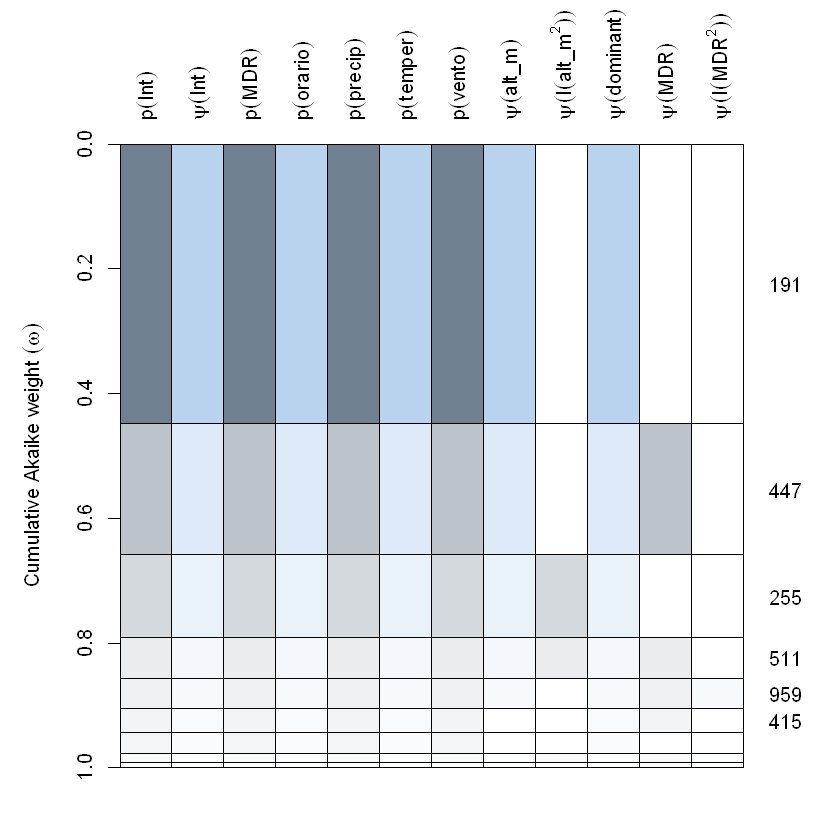

In [19]:
head(multimodel)
par(mfrow = c(1,1))
op <- par(mar = c(3,5,6,4), mfrow=c(1,1))
plot(multimodel, labAsExpr = TRUE)
par(op)


In [20]:
if (exists("sessione_analisi")) {
    save(list=c("multimodel", "arvicole", "siteCovs_orig","siteCovs_scaled"), file=paste0("Dati-modelli/multimodel_", anno_analisi,"_sessione_",sessione_analisi,"_",stri_rand_strings(1, 4, '[A-Z0-9]'),".RData"), compress=FALSE)
} else {
    save(list=c("multimodel", "arvicole", "siteCovs_orig","siteCovs_scaled"), file=paste0("Dati-modelli/multimodel_", anno_analisi,"_",stri_rand_strings(1, 4, '[A-Z0-9]'),".RData"), compress=FALSE)
}